# MNIST CNN 분류 모델 (복구 + 확장 버전)

이 노트북은 손상된 원본을 기반으로 재구성되었으며,
다음 기능을 포함합니다:

- CNN 모델 정의
- MNIST 데이터 로딩
- 모델 학습(Training)
- 검증(Validation)
- Confusion Matrix 시각화
- 샘플 예측 시각화


In [17]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager, rcParams
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def _configure_korean_font():
    candidates = [
        "Malgun Gothic", "맑은 고딕",
        "AppleGothic", "NanumGothic",
        "Noto Sans CJK KR", "Noto Sans KR", "Noto Sans CJK",
        "NanumBarunGothic", "Gulim", "Dotum", "Batang",
    ]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            rcParams["font.family"] = [name]
            rcParams["axes.unicode_minus"] = False
            return name
    rcParams["axes.unicode_minus"] = False
    return None

_configure_korean_font()

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


In [18]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)

len(train_set), len(test_set)

(60000, 10000)

In [19]:
# CNN Model 정의
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device

device(type='cuda')

In [20]:
# Training Loop
epochs = 10

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} "
        f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}"
    )


Epoch [1/10] Train Loss: 0.1228 | Train Acc: 0.9619 | Val Loss: 0.0503 | Val Acc: 0.9835
Epoch [2/10] Train Loss: 0.0372 | Train Acc: 0.9881 | Val Loss: 0.0343 | Val Acc: 0.9889
Epoch [3/10] Train Loss: 0.0227 | Train Acc: 0.9926 | Val Loss: 0.0336 | Val Acc: 0.9888
Epoch [4/10] Train Loss: 0.0137 | Train Acc: 0.9955 | Val Loss: 0.0461 | Val Acc: 0.9859
Epoch [5/10] Train Loss: 0.0119 | Train Acc: 0.9959 | Val Loss: 0.0363 | Val Acc: 0.9893
Epoch [6/10] Train Loss: 0.0082 | Train Acc: 0.9973 | Val Loss: 0.0456 | Val Acc: 0.9890
Epoch [7/10] Train Loss: 0.0080 | Train Acc: 0.9973 | Val Loss: 0.0377 | Val Acc: 0.9892
Epoch [8/10] Train Loss: 0.0062 | Train Acc: 0.9980 | Val Loss: 0.0517 | Val Acc: 0.9884
Epoch [9/10] Train Loss: 0.0055 | Train Acc: 0.9982 | Val Loss: 0.0501 | Val Acc: 0.9888
Epoch [10/10] Train Loss: 0.0044 | Train Acc: 0.9987 | Val Loss: 0.0486 | Val Acc: 0.9907


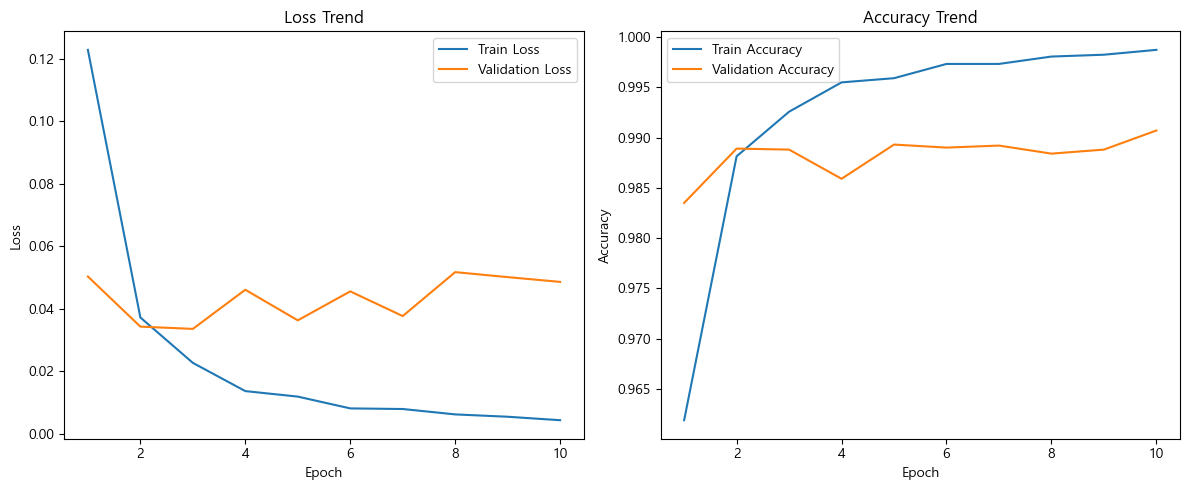

In [21]:
# Training / Validation Curves
if train_losses and val_losses:
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Trend")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Trend")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("먼저 학습 셀을 실행해 주세요.")


In [22]:
# Evaluation
model.eval()
correct = 0
total = 0
predictions = []
targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Accuracy:", correct / total)


Accuracy: 0.9907


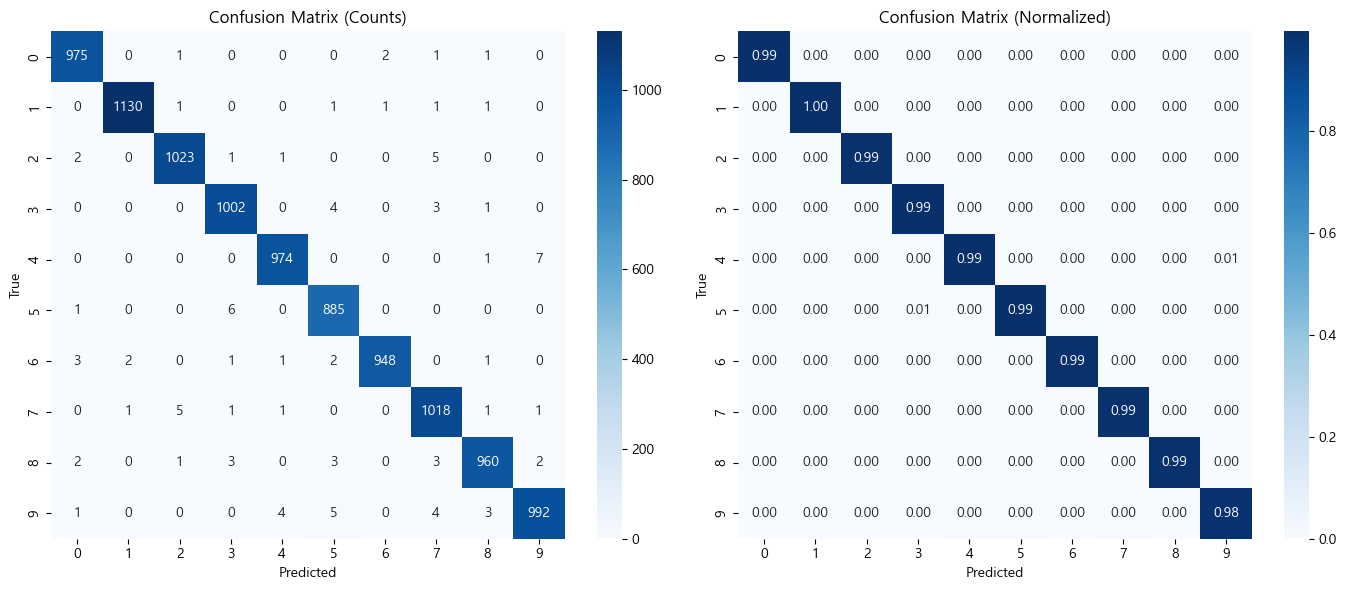

In [23]:
# Confusion Matrix

if not predictions or not targets or len(predictions) != len(targets):
    raise RuntimeError("Run the evaluation cell first to populate targets/predictions.")

labels = list(range(10))
cm_counts = confusion_matrix(targets, predictions, labels=labels)
cm_normalized = confusion_matrix(targets, predictions, labels=labels, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(
    cm_counts,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[0],
)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[1],
)
axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


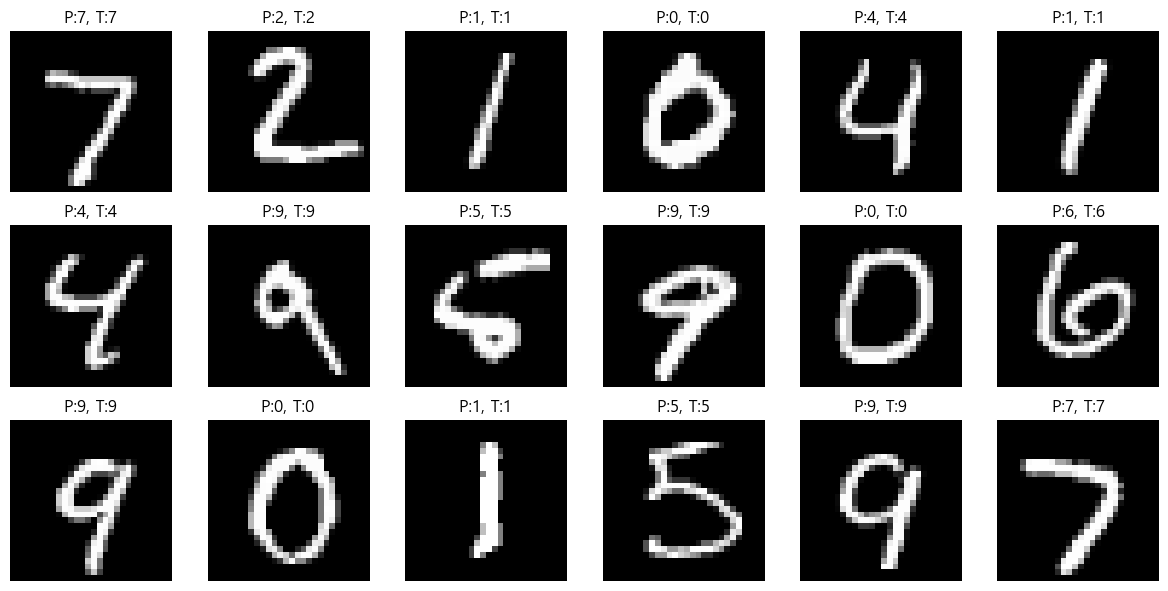

In [24]:
# 샘플 예측 확인
def show_samples():
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(3, 6, figsize=(12,6))
    idx = 0

    for i in range(3):
        for j in range(6):
            axes[i][j].imshow(images[idx].cpu().squeeze(), cmap="gray")
            axes[i][j].set_title(f"P:{preds[idx].item()}, T:{labels[idx].item()}")
            axes[i][j].axis("off")
            idx += 1

    plt.tight_layout()
    plt.show()

show_samples()
